<font size='+3'> <strong> Introduction </strong></font>

The purpose of this note is to provide an introduction to the Recovery module.

Recovery is the third and final step in our general experimental pipeline (data generation, reconstruction, and equations-of-motion recovery).

<strong>What is a model?</strong>

Here we concern ourselves with models of the form $\vec m_{t+1}$ = $\textbf{A} \phi(\vec y_t)$, where $\vec y_t$ is a vector of reconstructed data, $m_t$ is a vector of model-generated data, $\textbf{A}$ is a matrix of coefficients, and $\phi$ is a set of basis functions. TODO: Improve/clarify this notation.)

For example, the 1-D model $m_{t+1} = 3\sin(y_t) + 2\cos(y_t) + 3$ could be represented as $m_{t+1} = [3, 2, 3][1,  \cos(y_t),\sin(y_t)]^T$

In the case of continuous-time models, our model takes the form $\vec m_{t+1}$ = $y_t + \textbf{A} \phi(\vec y_t) dt$.

<strong>How do you pick a model?</strong>

Appealing to Occam's Razor, we attempt to find a model which balances model <i>complexity</i> ("size") with <i>accuracy</i>. Currently, we define accuracy according to least-squares error on a 1-step prediction vs the dataset. TODO: expound on this/clarify. We define size according to the number of nonzero (smaller than 1% of the second-largest term) elements of the A matrix. This corresponds to the number of active basis functions.

Okay, let's give it a go!

In [14]:
from recovery import *

<strong> <font size="+3"> Building a Model </font> </strong>

First we'll need a dataset to play with. For convenience, let's take some data from the Lorenz system we generated previously:

In [15]:
lorenzData = loadDataset('Lorenz_10000')

Typically here we would do some reconstruction to give us back our reconstructed data. In this case, I'll take my reconstruction to be the identity.

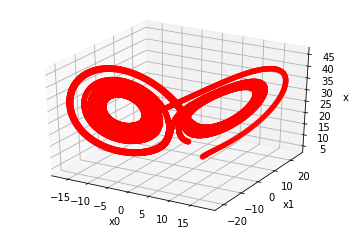

In [16]:
lorenzDataReconstructed = lorenzData
lorenzDataReconstructed.plot([0,1,2])

Now I'll build a model. In order to do this, I'll need to specify basis functions. There's a handy function which will allow me to quickly generate polynomial or sinusoidal basis functions up to some order in a single command.

In [17]:
reconstructionSymbols = [sympy.symbols(compName) for compName in lorenzData.componentNames]

print(getBasis('Taylor',3,reconstructionSymbols))

[1, x2, x1, x0, x2**2, x1*x2, x1**2, x0*x2, x0*x1, x0**2, x2**3, x1*x2**2, x1**2*x2, x1**3, x0*x2**2, x0*x1*x2, x0*x1**2, x0**2*x2, x0**2*x1, x0**3]


Now on to the actual model creation. First we must declare a model and give it an ID.

In [18]:
myModel = diffEqLinearModel('myModel')

Now I need to fill my dataset with a basis and find the appropriate coefficients to minimize single-step error. In the future, I'll be able to specify basis functions manually; for now, though, I've written up a one-line command to generate a polynomial or sinusoidal basis and fit our coefficients to the data.

In [19]:
reconstructedDataSet= lorenzDataReconstructed
basisType = 'Taylor'
order = 3

myModel.fastFillFromDataset(reconstructedDataSet,basisType,order)

And we're done. The model's been built: basis, coefficients, and all. I can print out the right-hand side of the equations of motion (small terms discarded):

In [20]:
for i in range(len(myModel.equations)): print('\dot ' + str(myModel.symbols[i])+' = '+str(myModel.equations[i]))

\dot x0 = -9.8111*x0 + 9.9456*x1
\dot x1 = -0.99354*x0*x2 + 27.851*x0 - 0.8615*x1
\dot x2 = 0.99376*x0*x1 - 2.6617*x2


I can also quickly check the least-squares error and model entropy:

In [21]:
print('Error')
print(myModel.error)
print('Entropy')
print(myModel.entropy)

Error
2.9032897939225676e-07
Entropy
-18.7158080814345


As with other modules, I can display lots of important model attributes all at once via info.

In [22]:
myModel.info()

Model Info:
ID: myModel
symbols: [x0, x1, x2]
basis: [1, x2, x1, x0, x2**2, x1*x2, x1**2, x0*x2, x0*x1, x0**2, x2**3, x1*x2**2, x1**2*x2, x1**3, x0*x2**2, x0*x1*x2, x0*x1**2, x0**2*x2, x0**2*x1, x0**3]

Short-Form Diff Equations: 
x0_{t+1} = -9.8111*x0 + 9.9456*x1
x1_{t+1} = -0.99354*x0*x2 + 27.851*x0 - 0.8615*x1
x2_{t+1} = 0.99376*x0*x1 - 2.6617*x2

Model Entropy: 
-18.7158080814345


<strong> <font size="+3"> Playing with the model </font> </strong>

I can use my model to generate datasets for analysis, too.

In [51]:
numPoints = 10000
initialConditions = [4,0,5]

modelGeneratedData = myModel.evolve(numPoints,initialConditions)
modeledDataset = dataset(modelGeneratedData)
print(modelGeneratedData[12])

[3.6164351990599637, 1.0395595731374119, 4.866103983238603]


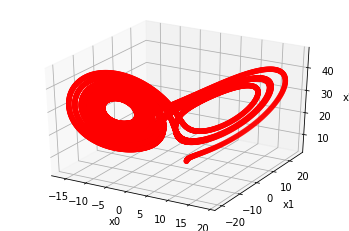

In [52]:
modeledDataset.plot([0,1,2])

Finally, I can quickly compute the Lyapunov Characteristic Exponents (LCEs) both the system and our model, for comparison:

In [25]:
print('LCEs of Original Lorenz System')
originalSystem = loadDataGenerator('Lorenz_Typical')
systemLCEs = getLCEs(originalSystem,nTransients = 1000, nIterates = 10000,nItsPerPB = 10)
print('Computed Lyapunov Spectrum: ')
print(systemLCEs)

LCEs of Original Lorenz System
Computing Transients
0.0%    100%
Computing LCEs
0.0%    21.52%    42.0%    63.46000000000001%    83.96000000000001%    100%
Computed Lyapunov Spectrum: 
[0.892492148949724, 0.010804127648734878, -14.569962933556605]


In [13]:
print('LCEs of Model')
modelLCEs = getLCEs(myModel,nTransients = 1000,nIterates = 10000,nItsPerPB = 10)
print(modelLCEs)

myModel.save('LorenzModel')

LCEs of Model
Computing Transients
0.0%    100%
Computing LCEs
0.0%    73.2%    100%
[0.9282286151116268, 0.007602168453787117, -14.270130774593895]


In [14]:
doesReadingWork = loadModel('LorenzModel')

In [18]:
doesReadingWork.additionalInfo['LCEs']= modelLCEs
print(doesReadingWork.additionalInfo['LCEs'])

[0.9282286151116268, 0.007602168453787117, -14.270130774593895]
